# Training a SNN Demapper with Receptive-field Encoding

More details can be found in [E. Arnold et al., “Spiking neural network nonlinear
demapping on neuromorphic hardware for IM/DD optical communication”](https://ieeexplore.ieee.org/abstract/document/10059327/).


In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import torch
import norse.torch as norse

import sys 
sys.path.insert(0, "/home/avb/CEL/Programme/imdd-halde/src") 
from IMDD import PAM4IMDD, IMDDModel, IMDDParams, helpers

## Receptive-field Encoding

One question when training a spiking demapper is how to best translate a chunk of real-valued data into a spiking representation in an efficient way.
The receptive-field encoding translates each samples $y_k$ in the chunk to a set of $K$ spiking neurons.
Each neuron has a `reference_point` assigned and its spike time is determined by the distance of $y_k$ to the given reference value.
This results in a spatio-temporal encoding with $K$ neurons per sample $k$.

We first create an IMDD link to generate data in order to visualize the input encoding:

In [2]:
params = IMDDParams(
    N=10000,
    n_taps=21,
    alphabet=torch.tensor([0., 1., np.sqrt(2), np.sqrt(3)]),
    oversampling_factor=3,
    baudrate=50*1e9,
    wavelength=0.000001550,
    dispersion_parameter=-0.000017,
    fiber_length=5000,
    noise_power_gain_db=20.,
    roll_off=0.2,
    bias=0.25)
link = IMDDModel(params)

## Generate some data
# Samples to send
samples = link.source()
print("Send symbols:\n", samples, samples.shape)

# Received samples
chunks = link(samples)
print("Received data (chunked):\n", chunks, chunks.shape)

Send symbols:
 tensor([3, 1, 1,  ..., 1, 0, 1]) torch.Size([10000])
Received data (chunked):
 tensor([[4.9853, 4.0772, 2.4113,  ..., 3.5843, 2.9625, 1.4257],
        [5.1387, 4.9853, 4.0772,  ..., 4.0490, 3.5843, 2.9625],
        [3.6973, 5.1387, 4.9853,  ..., 3.8416, 4.0490, 3.5843],
        ...,
        [4.5167, 4.7778, 1.2447,  ..., 1.7181, 1.0852, 4.8870],
        [2.4113, 4.5167, 4.7778,  ..., 1.4257, 1.7181, 1.0852],
        [4.0772, 2.4113, 4.5167,  ..., 2.9625, 1.4257, 1.7181]]) torch.Size([10000, 21])


Next we create an instance of the `ReceptiveFieldEncoder`. The encoding is defined by the `references` which we choose to be $10$ values equdistantly distributed in $[0, 7]$. The distance $y_k - \Chi_i$ is scaled by `scaling`. We neglect spikes which are later than `cutoff`.

In [3]:
#Wordlenght of the quantizer
K = 8
#Maximum input value of the quantizer
XMAX = 4

# Time resolution of encoding and SNN
dt = 1e-3
time_length = 0.01  # s

In [4]:
class BIT_MAPPER:
    ###### class global ######

    ####### Functions ########
    def __init__(self, w, device):
        self.change(w,device);

    def change(self,w,device):
        if(w <= 0):
            print("w has to be larger than 0");
            quit();
        else:
            self.__wordlenght = w;

        self.__device = device

        self.__map_mat = torch.linspace(0,self.__wordlenght-1,self.__wordlenght).to(self.__device)
        self.__map_mat = 2**self.__map_mat

    def give_wordlenght(self):
        return self.__wordlenght;
    def give_device(self):
        return self.__device;

    def map(self,bits):
        numbers = self.__map_mat @ torch.flip(bits,dims=[1]).T
        return numbers
 
    def demap(self,numbers):
        orig_shape = numbers.shape
        numbers = numbers.flatten()
        bit_list = [(numbers >> shift_ind) & 1 for shift_ind in range(self.__wordlenght)] # little endian
        bit_list.reverse() # big endian
        bits = torch.zeros((self.__wordlenght,numbers.shape[0]),device=self.__device)
        for n in range(len(bit_list)):
            bits[n] = bit_list[n]
        bits = bits.T
    
        bits = bits.unflatten(0,(orig_shape))

        return bits
        
def midtread_binary_unipolar(x,w,x_max):
    x = torch.clip(x,0,x_max)
    Delta_x = x_max / (2**(w));
    xh_uniform_midtread = torch.floor(torch.abs(x)/Delta_x+0.5);   #Select class from +/- 2**w-1/2
    xh_uniform_midtread = torch.clip(xh_uniform_midtread,0,2**w-1);        #Clip to 2**w-1
    xh_uniform_midtread = torch.ceil(xh_uniform_midtread).int();                 #Round up
    return Delta_x,xh_uniform_midtread


In [5]:
class Ternary_Encoder(torch.nn.Module):
    """ Class implementing the transmitter model """

    def __init__(self, wordlen=8, time=10, maximum_input_absolute = 4, device='cpu'):
        super().__init__()
        self.w = wordlen
        self.T = time
        self.xmax = maximum_input_absolute
        self.device = device
        self.bitmap = BIT_MAPPER(self.w,self.device)

    def forward(self,recv_symbols):
        rx = recv_symbols - torch.mean(recv_symbols)
        d_x,recv_q = midtread_binary_unipolar(torch.abs(rx),self.w,self.xmax)
        binary = self.bitmap.demap(recv_q)
        sign = torch.permute(torch.sign(rx).repeat(self.w,1,1),(1,2,0))
        tern_in_sym = binary*sign
        inputs = tern_in_sym.reshape( (1,tern_in_sym.shape[0],-1) )

        inputs = torch.vstack( (inputs,torch.zeros( (self.T-1,inputs.shape[1],inputs.shape[2]), device=self.device)) )

        return inputs


encoder = Ternary_Encoder(wordlen=K, time=int(time_length//dt), maximum_input_absolute = XMAX, device='cpu')

Now we encode the 10 first chunks into binary spike tensors. The first dimension in the resulting data is the time axis, which is 60, corresponding to 30 ms. This becomes clearer in the plot below.

In [6]:
spikes = encoder(chunks[:10])  # first ten samples
print("Spikes:\n", spikes, spikes.shape)

Spikes:
 tensor([[[ 1.,  0.,  0.,  ..., -0., -1., -0.],
         [ 1.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  1.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ..., -0., -1., -1.],
         [ 0.,  1.,  0.,  ..., -1., -0., -0.],
         [ 0.,  1.,  1.,  ..., -1., -0., -0.]],

        [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        ...,

        [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0., 

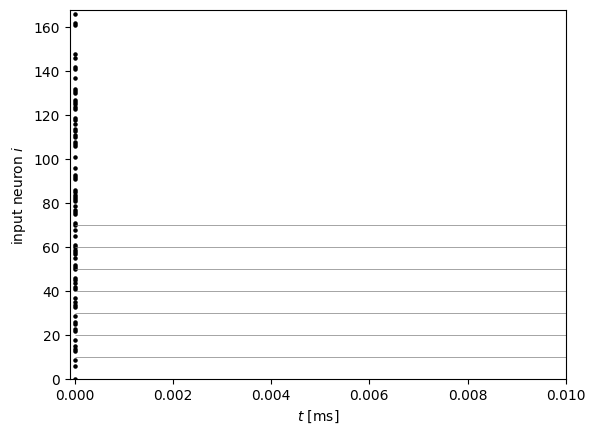

In [7]:
# Convert time-dense spikes into event-based spikes
events = torch.nonzero(spikes[:, 0])
time = np.linspace(0, time_length, int(time_length / dt))

fig, axes = plt.subplots(1)
axes.set_xlim(-0.0001, time_length)
axes.set_ylim(0, params.n_taps * K)
axes.set_xlabel("$t$ [ms]")
axes.set_ylabel("input neuron $i$")
axes.scatter(events[:, 0] * dt, events[:, 1], s=5, color="black")
axes.vlines(1.1*time_length, 0, params.n_taps * K, color="blue", ls=":")
for i in range(7):
    axes.hlines(10 * (i + 1), 0, 0.015, color="grey", lw=0.5)
plt.show()

# Model

In [8]:
class SNN_Perceptron_Equalizer(torch.nn.Module):
    def __init__(self, input_features, hidden_features, output_features,encoder,device, dt=0.001):
        super(SNN_Perceptron_Equalizer, self).__init__()
        self.device = device;

        self.encoder = encoder

        self.input_features  =  input_features
        self.hidden_features =  hidden_features
        self.output_features =  output_features

        self.dt = dt

        self.p  = norse.LIFParameters(
                    alpha       = torch.full((self.hidden_features,), torch.as_tensor(100.0)).to(device),
                    v_th        = torch.full((self.hidden_features,), torch.as_tensor(  1.0)).to(device),
                    v_leak      = torch.tensor(0.0).to(device),
                    v_reset     = torch.full((self.hidden_features,), torch.as_tensor(  0.0)).to(device),
                    tau_mem_inv = torch.full((self.hidden_features,), torch.as_tensor( 100.0)).to(device),
                    tau_syn_inv = torch.full((self.hidden_features,), torch.as_tensor( 200.0)).to(device))
        
        self.input_layer    = torch.nn.Linear(self.input_features        , self.hidden_features,bias=False).to(device);
        self.LIFRec_layer   = norse.LIFRecurrentCell(self.hidden_features, self.hidden_features,p=self.p,dt=dt,autapses=False).to(device);
        self.output_layer   = torch.nn.Linear(self.hidden_features       , self.output_features,bias=True).to(device);
    
    def __decode_sum(self,x):
        x = torch.sum(x,0);
        return x

    def forward(self, in_val):
        #States of the neurons
        state = None

        x = self.encoder(in_val)

        seq_length,batch_size,_ = x.shape

        self.LIFRec_spikes  = torch.zeros(x.shape[0], x.shape[1], self.hidden_features, device=self.device)
        z_rec          = torch.zeros(x.shape[1], self.hidden_features, device=self.device)

        out = torch.zeros(x.shape[0], x.shape[1], self.output_features, device=self.device)

        for ts in range(seq_length):
            z               =  self.input_layer(x[ts,:,:]);
            z,state            =  self.LIFRec_layer(z,state);
            self.LIFRec_spikes[ts,:,:]  = z;
            z               =  self.output_layer(z)
            
            out[ts][:][:]   =  z

        hidden_z = self.LIFRec_spikes;
        spikerate = torch.sum(hidden_z)/(hidden_z.shape[0]*hidden_z.shape[1]*hidden_z.shape[2])
        
        z = self.__decode_sum(out)
        return z, spikerate

# Training

In [9]:

def stats(loss: torch.Tensor, pred: torch.Tensor, data: torch.Tensor):
    ber = helpers.bit_error_rate(data, pred, False)
    acc = helpers.accuracy(data, pred, False)
    count = torch.count_nonzero(torch.argmax(pred, 1) != data)
    return ber, acc, count


def train(dataloader, optimizer, loss_fn, demapper, device):
    loss, acc, ber = [], [], []

    for i, (data, target) in enumerate(dataloader):
        optimizer.zero_grad()

        data = data.to(device)
        target = target.to(device)

        pred_b,_ = demapper(data)
        loss_b = loss_fn(pred_b, target)

        # Optimize
        loss_b.backward()
        optimizer.step()

        # Get stats
        ber_b, acc_b, _ = stats(loss_b, pred_b, target)

        # Accumualte
        loss.append(loss_b.detach())
        acc.append(acc_b)
        ber.append(ber_b)

    return (torch.stack(loss).reshape(-1).mean(),
            np.stack(acc).reshape(-1).mean(),
            np.stack(ber).reshape(-1).mean())


def test(dataloader, demapper, loss_fn, device, min_false_symbols, max_test_epochs):
    loss, acc, ber, n_false = [], [], [], 0

    for epoch in range(max_test_epochs):
        for i, (data, target) in enumerate(dataloader):

            data = data.to(device)
            target = target.to(device)

            pred_b,_ = demapper(data)
            loss_b = loss_fn(pred_b, target)

            ber_b, acc_b, count = stats(loss_b, pred_b, target)

            loss.append(loss_b.detach())
            acc.append(acc_b)
            ber.append(ber_b)

            n_false += count

        if n_false >= min_false_symbols:
            break

    return (torch.stack(loss).reshape(-1).mean(),
            np.stack(acc).reshape(-1).mean(),
            np.stack(ber).reshape(-1).mean(), n_false)

In [10]:
# The device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

# Training parameters
batch_size_train = 10000 
batch_size_val   = 10000 
lr = 0.01
epochs = 10000
min_false_symbols = 1000
max_test_epochs = 1000

TRAINING_params = IMDDParams(   noise_power_gain_db=17., #We train at 17dB and evaluate at 20dB
                                N=params.N,               #Rest stays as for the evaluation
                                n_taps=params.n_taps,
                                alphabet=params.alphabet,
                                oversampling_factor=params.oversampling_factor,
                                baudrate=params.baudrate,
                                wavelength=params.wavelength,
                                dispersion_parameter=params.dispersion_parameter,
                                fiber_length=params.fiber_length,
                                roll_off=params.roll_off,
                                bias=params.bias)

torch.manual_seed(0)
np.random.seed(0)

lif_demapper = SNN_Perceptron_Equalizer( K * params.n_taps,
                                            80,
                                            4,
                                            encoder=encoder,
                                            device=device, 
                                            dt = dt );

# Dataset
train_dataset = PAM4IMDD(TRAINING_params)
dataset = PAM4IMDD(params)

# Dataloader
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size_train, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset, batch_size_val, shuffle=True)

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# The SNRs we train the demapper for
op_point = 17

model_dir = Path("./models")
model_dir.mkdir(exist_ok=True)

print(f"SNR: {op_point}")
# update SNR in Dataset
train_dataset.simulator.params.noise_power_gain_db = op_point

# New scheduler
optimizer = torch.optim.Adam(lif_demapper.parameters(), lr=lr)

# train for SNR
# pbar = tqdm(total=epochs, unit="epoch")
val_data = torch.zeros((epochs // 10, 4))
best_val_ber = np.inf
for epoch in range(epochs):
    train_loss, train_acc, train_ber = train(
        train_loader, optimizer, loss_fn, lif_demapper, device)
    #print(f"Epoch={epoch}, loss={train_loss:.4f}, ber={train_ber:.7f}, "
    #      + f"acc={train_acc:.4f}")
    if epoch % 100 == 0:
        val_loss, val_acc, val_ber, n_false = test(
            val_loader, lif_demapper, loss_fn, device, min_false_symbols,
            max_test_epochs)

        # Save best Demapper
        if val_ber < best_val_ber:
            torch.save(
                lif_demapper.state_dict(), f"./models/snr_{int(op_point)}.pt")
            best_val_ber = val_ber
        print(str(train_dataset.simulator.params.noise_power_gain_db)+" dB")
        print(f"Training Epoch={epoch}, loss={train_loss:.4f}, ber={train_ber:.7f}, "
              + f"acc={train_acc:.4f}")
        print(str(dataset.simulator.params.noise_power_gain_db)+" dB")
        print(f"Evaluation, val_loss={val_loss:.4f}, "
                + f"val_ber={val_ber:.7f}, val_acc={val_acc:.4f}, "
                 + f"n_false={n_false}")


Using device:  cpu
SNR: 17
17 dB
Training Epoch=0, loss=1.4092, ber=0.4950500, acc=0.2507
20.0 dB
Evaluation, val_loss=1.3909, val_ber=0.5033000, val_acc=0.2477, n_false=7523
17 dB
Training Epoch=100, loss=0.2171, ber=0.0444500, acc=0.9111
20.0 dB
Evaluation, val_loss=0.1373, val_ber=0.0241500, val_acc=0.9517, n_false=1449
17 dB
Training Epoch=200, loss=0.1914, ber=0.0381500, acc=0.9237
20.0 dB
Evaluation, val_loss=0.1157, val_ber=0.0199000, val_acc=0.9602, n_false=1194
17 dB
Training Epoch=300, loss=0.1786, ber=0.0364500, acc=0.9271
20.0 dB
Evaluation, val_loss=0.0969, val_ber=0.0158375, val_acc=0.9683, n_false=1267
17 dB
Training Epoch=400, loss=0.1488, ber=0.0281000, acc=0.9438
20.0 dB
Evaluation, val_loss=0.0710, val_ber=0.0111500, val_acc=0.9777, n_false=1115
17 dB
Training Epoch=500, loss=0.1639, ber=0.0310000, acc=0.9380
20.0 dB
Evaluation, val_loss=0.0621, val_ber=0.0094500, val_acc=0.9811, n_false=1134
17 dB
Training Epoch=600, loss=0.1341, ber=0.0265000, acc=0.9470
20.0 dB
Ev

In [11]:
# Test demapper on independet data

#SNRS to test the demapper
snrs = torch.arange(15., 24., 1.)

torch.manual_seed(42)
np.random.seed(42)

min_false_symbols = 2000

# Dataset and loader
dataset = PAM4IMDD(params)
test_loader = torch.utils.data.DataLoader(
    dataset, batch_size_val, shuffle=False)

bers = np.zeros((snrs.shape[0], 3))

for s, snr in enumerate(snrs):
    # Set SNR in dataset
    dataset.simulator.params.noise_power_gain_db = snr.item()

    # Load best model for current SNR
    state_dict = torch.load(f"./models/snr_{int(op_point)}.pt")
    lif_demapper.load_state_dict(state_dict)

    loss, acc, ber, n_false = [], [], [], 0

    ber = []
    while True:
        for i, (data, target) in enumerate(test_loader):

            data = data.to(device)
            target = target.to(device)

            pred_b,_ = lif_demapper(data)

            ber_b = helpers.bit_error_rate(target, pred_b, False)
            ber.append(ber_b)

            n_false += torch.count_nonzero(torch.argmax(pred_b, 1) != target)

        if n_false >= min_false_symbols:
            break

    bers[s, 0] = snr
    bers[s, 1] = np.stack(ber).reshape(-1).mean()
    bers[s, 2] = n_false

    print(f"Tested Demapper for {snr}. BER = {bers[s, 1]}, n_false = {n_false}")

np.save("test_bers.npy", bers)


Tested Demapper for 15.0. BER = 0.03475, n_false = 2084
Tested Demapper for 16.0. BER = 0.02399, n_false = 2399
Tested Demapper for 17.0. BER = 0.013468749999999998, n_false = 2154
Tested Demapper for 18.0. BER = 0.008073076923076922, n_false = 2099
Tested Demapper for 19.0. BER = 0.0039250000000000005, n_false = 2041
Tested Demapper for 20.0. BER = 0.001819090909090909, n_false = 2001
Tested Demapper for 21.0. BER = 0.0007575187969924812, n_false = 2015
Tested Demapper for 22.0. BER = 0.00027127371273712734, n_false = 2002
Tested Demapper for 23.0. BER = 9.197247706422019e-05, n_false = 2005


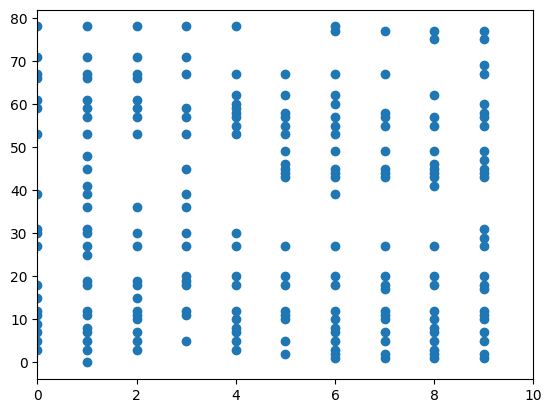

In [12]:
# Plot first sample in last batch
events = torch.nonzero(lif_demapper.LIFRec_spikes.detach().cpu()[:, 0, :]).numpy()

_, axs = plt.subplots(nrows=1)
axs.set_xlim(0, 10)
axs.scatter(events[:, 0], events[:, 1])
#axs[1].plot(lif_demapper.v_lif.detach().cpu().numpy()[:, 0])
#axs[2].plot(lif_demapper.traces.detach().cpu().numpy()[:, 0])

## Plot BER-SNR curve

<>:13: SyntaxWarning: invalid escape sequence '\l'
<>:13: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_41263/4174635699.py:13: SyntaxWarning: invalid escape sequence '\l'
  axs.set_xlabel("$−10 \log_{10}(\sigma^2)$ [dB]")
/tmp/ipykernel_41263/4174635699.py:13: SyntaxWarning: invalid escape sequence '\l'
  axs.set_xlabel("$−10 \log_{10}(\sigma^2)$ [dB]")


LatexError: LaTeX errored (probably missing font or error in preamble) while processing the following input:
\documentclass{article}
% !TeX program = xelatex
\usepackage{graphicx}
\def\mathdefault#1{#1}
\everymath=\expandafter{\the\everymath\displaystyle}

\ifdefined\pdftexversion\else  % non-pdftex case.
  \usepackage{fontspec}
  \setmainfont{DejaVuSerif.ttf}[Path=\detokenize{/home/avb/CEL/Programme/SNN_ENV/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/}]
  \setsansfont{DejaVuSans.ttf}[Path=\detokenize{/home/avb/CEL/Programme/SNN_ENV/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/}]
  \setmonofont{DejaVuSansMono.ttf}[Path=\detokenize{/home/avb/CEL/Programme/SNN_ENV/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/}]
\fi
\makeatletter\@ifpackageloaded{underscore}{}{\usepackage[strings]{underscore}}\makeatother
\begin{document}
\typeout{pgf_backend_query_start}
This is XeTeX, Version 3.141592653-2.6-0.999996 (TeX Live 2024/Arch Linux) (preloaded format=xelatex)
 restricted \write18 enabled.
**---! /var/lib/texmf/web2c/xetex/xelatex.fmt made by different executable version, strings are different
(Fatal format file error; I'm stymied)


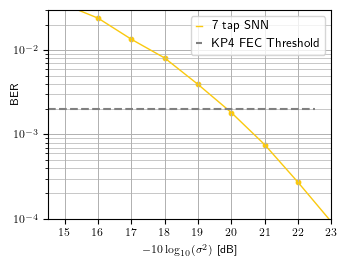

In [13]:
data = np.load("./test_bers.npy")


params = {'text.usetex' : True,
          'font.size' : 8,
          }
plt.rcParams.update(params)

color = ["#FAC90F", "#FA8D0F", "#0F69FA", "#7A6F45"]

fig, axs = plt.subplots(figsize=(3.5, 2.7))
axs.set_ylabel("BER")
axs.set_xlabel("$−10 \log_{10}(\sigma^2)$ [dB]")
axs.set_yscale("log")
axs.set_ylim(1e-4, 3e-2)
axs.set_xlim(14.5, 22.5)
axs.set_xticks(data[:, 0])
axs.plot(data[:, 0], data[:, 1], lw=1, color=color[0], label=r"7 tap SNN")
axs.scatter(data[:, 0], data[:, 1], color=color[0], s=10)
axs.hlines(2e-3, 14.5, 22.5, color="grey", ls="--", label="KP4 FEC Threshold")
axs.grid(which="minor", lw=0.5)
axs.grid(which="major", lw=0.7)
axs.yaxis.set_label_coords(-0.1, 0.6)
axs.legend(fontsize=9, handlelength=0.5)
plt.tight_layout()
plt.savefig("./snr.pgf")